## Присоединяйтесь к чату воркшопа:
# https://clck.ru/9yRpd
## Подходите за материалами (на флешках)

# Один день из жизни нагрузочного тестировщика
## Алексей Лавренюк, Яндекс

Процесс нагрузочного тестирования:

* Анализ работы сервиса:
  * архитектура
  * нагрузка (планируемая или существующая)
* Подготовка стрельб
  * настройка тестового стенда
  * подготовка патронов
* [Стрельбы](http://www.failoverconf.ru/upload/iblock/8ce/2_01_YandexTank.pdf)
* Анализ результатов
  
Из вышеперечисленного сегодня мы займемся анализом входной нагрузки и анализом результатов стрельб.

## Задачка 0: готовим тестовое окружение

Логи, с которыми мы будем работать -- на флешках:

* `access_log_Jul95` -- логи веб-сервера NASA Kennedy Space Center за июль 1995 года
* `phout_1` и `phout_2` -- логи стрельб Яндекс.Танком

Страничка с описанием логов NASA: http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html

Если будете использовать jupyter, запустите его в той папке, куда скачали логи.

Проверьте, что библиотеки имортируются:
```
import numpy as np    # numpy
import pandas as pd   # pandas

# альтернативная библиотека для визуализации
# https://github.com/mwaskom/seaborn
import seaborn as sns

# подключаем графику прямо в браузер
%matplotlib inline
```
Если нет -- самое время их поставить.
```
sudo -H pip3 install numpy pandas seaborn
```
Если вы под ubuntu, вероятно, для сборки этих библиотек вам понадобятся:
```
sudo apt install build-essential python-dev gfortran
```

# Парсим access.log

In [ ]:
# немного о jupyter. vim-like, помощь, автодополнение

In [3]:
import numpy as np
?np.linspace

In [4]:
%%bash
# можно исполнять bash-команды прямо отсюда

head ./access_log_Jul95

199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245
unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985
199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085
burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0
199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179
burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0
burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0
205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985
d104.aa.net - - [01/Jul/1995:00:00:13 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985
129.94.144.152 - - [01/Jul/1995:00:00:13 -0400] "GET / HTTP/1.0" 

In [5]:
# мы на PyCon, поэтому будем работать с помощью преимущественно в Python

# читаем первую строку:
with open("./access_log_Jul95") as datafile:
    log_line = datafile.readline()
print(log_line)

199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245



## Задачка 1: парсим access.log

**Задание**
Написать функцию `parse_line`, которая принимает на вход строку из лога и возвращает массив полей:
* hostname - имя хоста, например `199.72.81.55`
* date - дата в виде строки, например `01/Jul/1995:00:00:01 -0400`
* method - метод, указанный в запросе, например `GET`
* url - url, указанный в запросе, например `/history/apollo/`
* response_code - код ответа, например `200`
* size - размер ответа, например `6245`

**вспомогательные материалы**
* функции [split](https://docs.python.org/3.5/library/stdtypes.html#str.split), [rsplit](https://docs.python.org/3.5/library/stdtypes.html#str.rsplit) и [strip](https://docs.python.org/3.5/library/stdtypes.html#str.strip)
* документация по [regex](https://docs.python.org/3/library/re.html) в питоне (а именно [re.match](https://docs.python.org/3/library/re.html#re.match))
* [сервис](http://rubular.com) для тестирования регэкспов

**заготовка кода**
```
with open("./access_log_Jul95") as datafile:
    log_line = datafile.readline()

def parse_line(line):
    # ваш код тут
    return []
    
print(parse_line(log_line))
```

In [29]:
# andrey-yantsen
def parse_line_t(line):
    ip, _, _, dt, tz, method, path, _, responce_code, size = line.split(' ')
    return ip, dt + tz, method.replace('"', ''), path, responce_code, size

def parse_line_t(line):
    ip, _, _, dt, tz, method, path, _, responce_code, size = line.split(' ')
    return ip, (dt + tz).replace('[', '').replace(']', ''), method.replace('"', ''), path, responce_code, size.strip()

print(parse_line_t(log_line))

('199.72.81.55', '01/Jul/1995:00:00:01-0400', 'GET', '/history/apollo/', '200', '6245')


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [8]:
# вариант с регэксом

import re

# регэкс скомпилим заранее
regex = re.compile('([\w\-\.]+) - - \[(.*?)\] "([A-Z]+) (\S+)\s+(\S+)" (\d+) (\d+)')
def parse_line_re(line):
    return regex.match(line).groups()

parse_line_re(log_line)

('199.72.81.55',
 '01/Jul/1995:00:00:01 -0400',
 'GET',
 '/history/apollo/',
 'HTTP/1.0',
 '200',
 '6245')

In [9]:
# вариант без регэкспа: постепенно откусываем поля по известным разделителям

def parse_line_split(line):
    host, line = line.split(" ", 1)
    _, line = line.split("[", 1)
    date, line = line.split("]", 1)
    _, line = line.split('"', 1)
    req, line = line.split('"', 1)
    code, timing = line.strip("\r\n ").split()
    return [host, date] + req.split(" ") + [code, timing]

parse_line_split(log_line)

['199.72.81.55',
 '01/Jul/1995:00:00:01 -0400',
 'GET',
 '/history/apollo/',
 'HTTP/1.0',
 '200',
 '6245']

In [31]:
%timeit parse_line_re(log_line)
%timeit parse_line_split(log_line)

%timeit parse_line_t(log_line)

100000 loops, best of 3: 2.57 µs per loop
100000 loops, best of 3: 3.74 µs per loop
The slowest run took 4.26 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.91 µs per loop


## Тестируем на нашем логе

In [16]:
def test_parser_on_file(parser):
    with open("./access_log_Jul95") as datafile:
        for line in datafile:
            try:
                parser(line)
            except Exception as e:
                # если парсер не сработает, напечатаем строку,
                # на которой он сломался, и выйдем
                print(line)
                raise e

In [17]:
# сначала попробуем на функции, которая ничего не делает
# python 2 работает по-другому =)
test_parser_on_file(lambda l: l)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 3690: invalid start byte

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [18]:
%%bash
# посмотрим, что же это за 0x80

hexdump ./access_log_Jul95 | grep -m 1 ' 80 '

0c86e60 6e 74 64 6f 77 6e 2f 64 79 20 80 3f 73 68 75 74


In [19]:
%%bash

xxd ./access_log_Jul95 | grep '0c86e60' -C 2 -m 1

0c86e40: 323a 3234 3a34 3120 2d30 3430 305d 2022  2:24:41 -0400] "
0c86e50: 4745 5420 2f73 6875 7474 6c65 2f63 6f75  GET /shuttle/cou
0c86e60: 6e74 646f 776e 2f64 7920 803f 7368 7574  ntdown/dy .?shut


In [20]:
# пофиксим читалку файла
def test_parser_on_file(parser):
    with open("./access_log_Jul95", encoding="ascii", errors="replace") as datafile:
        for line in datafile:
            try:
                parser(line)
            except Exception as e:
                # если парсер не сработает, напечатаем строку,
                # на которой он сломался, и выйдем
                print(line)
                raise e

test_parser_on_file(lambda l: l)

In [21]:
# протестируем вариант с регэкспом
test_parser_on_file(parse_line_re)

dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -



AttributeError: 'NoneType' object has no attribute 'groups'

In [22]:
test_parser_on_file(parse_line_t)

pipe6.nyc.pipeline.com - - [01/Jul/1995:00:22:43 -0400] "GET /shuttle/missions/sts-71/movies/sts-71-mir-dock.mpg" 200 946425



ValueError: not enough values to unpack (expected 10, got 9)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [23]:
# если сервер возвращает ошибку, то размера нет
# добавим поддержку для отсутствующего размера
regex = re.compile('([\w\-\.]+) - - \[(.*?)\] "([A-Z]+) (\S+)\s+(\S+)" (\d+) (-|\d+)')
def parse_line_re(line):
    return regex.match(line).groups()

# и проверим, что все работает на этой строке
parse_line_re('dd15-062.compuserve.com - - [01/Jul/1995:00:01:12 -0400] "GET /news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt HTTP/1.0" 404 -')

# кстати, если бы мы парсили не регэкспом, а вручную, мы могли бы в случае отсутствия значения поставить там 
# 0 или None, и потом нам было бы удобнее работать с такими данными

('dd15-062.compuserve.com',
 '01/Jul/1995:00:01:12 -0400',
 'GET',
 '/news/sci.space.shuttle/archive/sci-space-shuttle-22-apr-1995-40.txt',
 'HTTP/1.0',
 '404',
 '-')

In [24]:
# попробуем еще раз
test_parser_on_file(parse_line_re)

pipe6.nyc.pipeline.com - - [01/Jul/1995:00:22:43 -0400] "GET /shuttle/missions/sts-71/movies/sts-71-mir-dock.mpg" 200 946425



AttributeError: 'NoneType' object has no attribute 'groups'

In [25]:
# учитываем возможное отсутствие протокола в запросе
regex = re.compile('([\w\-\.]+) - - \[(.*?)\] "([A-Z]+) (\S+)(?: (\S+))?" (\d+) (-|\d+)')
def parse_line_re(line):
    return regex.match(line).groups()

parse_line_re('pipe6.nyc.pipeline.com - - [01/Jul/1995:00:22:43 -0400] "GET /shuttle/missions/sts-71/movies/sts-71-mir-dock.mpg" 200 946425')

('pipe6.nyc.pipeline.com',
 '01/Jul/1995:00:22:43 -0400',
 'GET',
 '/shuttle/missions/sts-71/movies/sts-71-mir-dock.mpg',
 None,
 '200',
 '946425')

In [27]:
# посмотрим все необработанные строки (опасно, но я пробовал)
regex = re.compile('([\w\-\.@]+) - - \[(.*?)\] "([A-Z]+) (\S+)(?:\s+(\S+))?" (\d+) (-|\d+)')
def parse_line_re(line):
    try:
        return regex.match(line).groups()
    except AttributeError:
        print(line)
        # не будем бросать тут эксепшн, просто продолжим
        raise
        return None
test_parser_on_file(parse_line_re)

204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502

204.120.229.63 - - [01/Jul/1995:04:29:05 -0400] "GET /history/history.html                                                 hqpao/hqpao_home.html HTTP/1.0" 200 1502



AttributeError: 'NoneType' object has no attribute 'groups'

## Задачка 2: починка парсера

**Задание** Починить парсер хотя бы для тех ответов, которые обработал сервер
* нераспаршенными должны остаться только те ответы, на которые сервер выдал код 400 (bad request)
* предположим, что сервер читает url до первого пробельного символа, все остальное выкидывает

**Заготовка кода**

Можно либо поменять регулярное выражение, либо использовать свою функцию.
```
import re

def test_parser_on_file(parser):
    with open("./access_log_Jul95", encoding="ascii", errors="replace") as datafile:
        for line in datafile:
            try:
                parser(line)
            except Exception as e:
                # если парсер не сработает, напечатаем строку,
                # на которой он сломался, и выйдем
                print(line)
                raise e

regex = re.compile('([\w\-\.@]+) - - \[(.*?)\] "([A-Z]+) (\S+)(?:\s+(\S+))?" (\d+) (-|\d+)')
def parse_line_re(line):
    try:
        return regex.match(line).groups()
    except AttributeError:
        print(line)
        return None

test_parser_on_file(parse_line_re)
```

In [34]:
#briskly
import re
def parse_line(line):
    res = re.match(r"(.*)- - (\[.*\]) \"(\w+) (.+)( (.+))?\" (\d+) (\d+|-)", line)
    if res is None:
        print(line)
        return
    return res.groups()

def parser_log(fn):
    for line in open(fn, encoding="ascii", errors="replace"):
        res = parse_line(line)
        if res:
            pass

parser_log("access_log_Jul95")

klothos.crl.research.digital.com - - [10/Jul/1995:16:45:50 -0400] "" 400 -

firewall.dfw.ibm.com - - [20/Jul/1995:07:34:34 -0400] "1/history/apollo/images/" 400 -

firewall.dfw.ibm.com - - [20/Jul/1995:07:53:24 -0400] "1/history/apollo/images/" 400 -

128.159.122.20 - - [20/Jul/1995:15:28:50 -0400] "k��tx��tG��t���" 400 -

128.159.122.20 - - [24/Jul/1995:13:52:50 -0400] "k��tx��tG��t���" 400 -

alyssa.p


In [28]:
# beloborodov
def parse_line(line):
    return re.search('(.*) - - \[(.*)\] "(.*) (\/.*) HTTP/1.0" (.*) (.*)', line).groups()
test_parser_on_file(parse_line)

pipe6.nyc.pipeline.com - - [01/Jul/1995:00:22:43 -0400] "GET /shuttle/missions/sts-71/movies/sts-71-mir-dock.mpg" 200 946425



AttributeError: 'NoneType' object has no attribute 'groups'

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

**что получилось у меня**
* запросом считаем то, что после метода и до первого пробельного символа, далее выкидываем все до последней кавычки
* учитываем то, что после метода перед урлом может быть не один пробел
* добавил все символы, которые встречались в хостнеймах. Можно было просто ограничить хостнейм первым пробельным символом, но мне было интересно, какие бывают хостнеймы

In [35]:
regex = re.compile('([\w\-\.@\'*,:/#&]+) - - \[(.*?)\] "([A-Z]+)\s+(\S+).*" (\d+) (-|\d+)')
def parse_line_re(line):
    try:
        return regex.match(line).groups()
    except AttributeError:
        print(line)
        # не кидаем эксепшн, посмотрим все нераспаршенные строки
        return None
test_parser_on_file(parse_line_re)

klothos.crl.research.digital.com - - [10/Jul/1995:16:45:50 -0400] "" 400 -

firewall.dfw.ibm.com - - [20/Jul/1995:07:34:34 -0400] "1/history/apollo/images/" 400 -

firewall.dfw.ibm.com - - [20/Jul/1995:07:53:24 -0400] "1/history/apollo/images/" 400 -

128.159.122.20 - - [20/Jul/1995:15:28:50 -0400] "k��tx��tG��t���" 400 -

128.159.122.20 - - [24/Jul/1995:13:52:50 -0400] "k��tx��tG��t���" 400 -

alyssa.p


# Считаем урлы

In [36]:
# убираем печать ненайденных урлов, чтобы не мешались

regex = re.compile('([\w\-\.@\'*,:/#&]+) - - \[(.*?)\] "([A-Z]+)\s+(\S+).*" (\d+) (-|\d+)')
def parse_line_re(line):
    try:
        return regex.match(line).groups()
    except AttributeError:
        return None


In [37]:
from collections import defaultdict

# нас интересуют урлы без параметров, параметры могут быть и через хеш, и через вопрос
# отделим их с помощью регэкспа
delim = re.compile("[#?]")

counts = defaultdict(int)
with open("./access_log_Jul95", encoding="ascii", errors="replace") as datafile:
    for line in datafile:
        fields = parse_line_re(line)
        if fields:
            uri = delim.split(fields[3])[0]
            counts[uri] += 1
counts

defaultdict(int,
            {'/history/apollo/apollo-13/images/70HC418.GIF': 616,
             '/shuttle/missions/sts-71/news/ksc-status-06-07-95.txt': 4,
             '/shuttle/missions/sts-51/': 18,
             '/images/home_igloo.gif': 2,
             '/history/aoillo/': 1,
             '/shuttle/movies/astronauts.mpg': 39,
             '/history/mercury/mercury-capsules.txt': 6,
             '/news/sci.space.news/1552': 2,
             '/HISTORY/APOLLO/APOLLO-13/APOLLO13.HTML': 2,
             '/shuttle/missions/sts-2/movies/': 11,
             '/shuttle/missions/sts-71/images/KSC-95EC-0873.jpeg': 1,
             '/11/history/gemini/gemini-4/news/': 1,
             '/images/lc39a.gif': 669,
             '/home/guided-tour.html': 1,
             '/procurement/midrange/rfo/consamp.txt': 15,
             '/shuttle/missions/status/r91-61': 1,
             '/shuttle/technology/sts-newsref/stsover-missions': 1,
             '/statistics/1993/Nov/Nov93_byte.gif': 1,
             '/shutt

In [38]:
import json
with open("urls.json", "w") as of:
    json.dump(counts, of, indent=2)

## Задачка 3: топ 10 урлов

**Задание** Найти 10 самых посещаемых урлов и число посещений для каждого из них

**Заготовка кода**
```
import re
from collections import defaultdict

regex = re.compile('([\w\-\.@\'*,:/#&]+) - - \[(.*?)\] "([A-Z]+)\s+(\S+).*" (\d+) (-|\d+)')
def parse_line_re(line):
    try:
        return regex.match(line).groups()
    except AttributeError:
        return None

# нас интересуют урлы без параметров, параметры могут быть и через хеш, и через вопрос
# отделим их с помощью регэкспа
delim = re.compile("[#?]")

def count_urls():
    counts = defaultdict(int)
    with open("./access_log_Jul95", encoding="ascii", errors="replace") as datafile:
        for line in datafile:
            fields = parse_line_re(line)
            if fields:
                uri = delim.split(fields[3])[0]
                counts[uri] += 1
    return counts
    
def top_ten():
    # ваш код здесь
    return []
```

In [41]:
#andrey-yantsen
import json
urls = json.loads(open('urls.json').read())
list(sorted(urls.items(), key=lambda x: x[1], reverse=True))[:10]

[('/images/NASA-logosmall.gif', 111388),
 ('/images/KSC-logosmall.gif', 89639),
 ('/images/MOSAIC-logosmall.gif', 60468),
 ('/images/USA-logosmall.gif', 60014),
 ('/images/WORLD-logosmall.gif', 59489),
 ('/images/ksclogo-medium.gif', 58802),
 ('/images/launch-logo.gif', 40871),
 ('/shuttle/countdown/', 40279),
 ('/ksc.html', 40232),
 ('/images/ksclogosmall.gif', 33585)]

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [42]:
# не оптимально, но нас устроит
list(reversed(sorted(counts.items(), key=lambda x: x[1])))[:10]

[('/images/NASA-logosmall.gif', 111388),
 ('/images/KSC-logosmall.gif', 89639),
 ('/images/MOSAIC-logosmall.gif', 60468),
 ('/images/USA-logosmall.gif', 60014),
 ('/images/WORLD-logosmall.gif', 59489),
 ('/images/ksclogo-medium.gif', 58802),
 ('/images/launch-logo.gif', 40871),
 ('/shuttle/countdown/', 40279),
 ('/ksc.html', 40232),
 ('/images/ksclogosmall.gif', 33585)]

# Подключаем Pandas

In [43]:
import numpy as np    # numpy
import pandas as pd   # pandas

# альтернативная библиотека для визуализации
# https://github.com/mwaskom/seaborn
import seaborn as sns

# подключаем графику прямо в браузер
%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [44]:
# основное понятие в Pandas -- DataFrame
df = pd.DataFrame([
        ["Stuart Bloom", False, 50],
        ["Sheldon Cooper", True, 2000],
        ["Amy Farrah Fowler", False, 1200],
        ["Radjesh Koothrappali", False, 1000],
        ["Howard Wolowitz", False, 1500],
        ["Bernadette Rostenkowski", True, 2100],
        ["Penny", True, 5000],
        ["Leonard Hofstadter", True, 2500],
    ], columns="name pythonista salary".split())

df

,name,pythonista,salary
0,Stuart Bloom,False,50
1,Sheldon Cooper,True,2000
2,Amy Farrah Fowler,False,1200
3,Radjesh Koothrappali,False,1000
4,Howard Wolowitz,False,1500
5,Bernadette Rostenkowski,True,2100
6,Penny,True,5000
7,Leonard Hofstadter,True,2500


In [45]:
# селектим только питонистов
df[df['pythonista']]

,name,pythonista,salary
1,Sheldon Cooper,True,2000
5,Bernadette Rostenkowski,True,2100
6,Penny,True,5000
7,Leonard Hofstadter,True,2500


In [46]:
# как это работает? Индексация по массиву значений.
df['pythonista']

0    False
1     True
2    False
3    False
4    False
5     True
6     True
7     True
Name: pythonista, dtype: bool

In [47]:
df[[False, False, True, False, False, False, False, False]]

,name,pythonista,salary
2,Amy Farrah Fowler,False,1200


In [48]:
# выберем только интересные нам колонки
df[['pythonista', 'salary']]

,pythonista,salary
0,False,50
1,True,2000
2,False,1200
3,False,1000
4,False,1500
5,True,2100
6,True,5000
7,True,2500


In [49]:
print(type(df['pythonista']))
df['pythonista']

<class 'pandas.core.series.Series'>


0    False
1     True
2    False
3    False
4    False
5     True
6     True
7     True
Name: pythonista, dtype: bool

In [51]:
# можно и так, но надо быть аккуратнее. Если колонка называется, например, size,
# то не сработает -- потому что есть функция с таким же названием
print(type(df.pythonista))
df.pythonista

<class 'pandas.core.series.Series'>


0    False
1     True
2    False
3    False
4    False
5     True
6     True
7     True
Name: pythonista, dtype: bool

In [50]:
# выбираем одну колонку как датафрейм
print(type(df[['pythonista']]))
df[['pythonista']]

<class 'pandas.core.frame.DataFrame'>


,pythonista
0,False
1,True
2,False
3,False
4,False
5,True
6,True
7,True


In [52]:
# добавим новую колонку, приготовив ее из старой
df['first_name'] = df['name'].apply(lambda x: x.split()[0])
df

,name,pythonista,salary,first_name
0,Stuart Bloom,False,50,Stuart
1,Sheldon Cooper,True,2000,Sheldon
2,Amy Farrah Fowler,False,1200,Amy
3,Radjesh Koothrappali,False,1000,Radjesh
4,Howard Wolowitz,False,1500,Howard
5,Bernadette Rostenkowski,True,2100,Bernadette
6,Penny,True,5000,Penny
7,Leonard Hofstadter,True,2500,Leonard


## Задачка 4: Добавить фамилию

**Задание** Добавить колонку с фамилией. Если фамилия двойная, в колонке должны быть обе ее части. Если фамилии нет, то в колонке должно быть None

**Заготовка кода**
```
df = pd.DataFrame([
        ["Stuart Bloom", False, 50],
        ["Sheldon Cooper", True, 2000],
        ["Amy Farrah Fowler", False, 1200],
        ["Radjesh Koothrappali", False, 1000],
        ["Howard Wolowitz", False, 1500],
        ["Bernadette Rostenkowski", True, 2100],
        ["Penny", True, 5000],
        ["Leonard Hofstadter", True, 2500],
    ], columns="name pythonista salary".split())
    
# тут ваш код
```

In [54]:
# andrey-yantsen
df['name'].apply(lambda x: '' if ' ' not in x else x.split(' ')[1])

0           Bloom
1          Cooper
2          Farrah
3    Koothrappali
4        Wolowitz
5    Rostenkowski
6                
7      Hofstadter
Name: name, dtype: object

In [55]:
def ln(i):                            
    names = i.split()
    try:
        return names[1]
    except IndexError:
        return names[0]
df['name'].apply(ln)

0           Bloom
1          Cooper
2          Farrah
3    Koothrappali
4        Wolowitz
5    Rostenkowski
6           Penny
7      Hofstadter
Name: name, dtype: object

In [56]:
#khudyakovavi
df['name'].apply(lambda x: None if ' ' not in x else ' '.join(x.split()[1:]))

0            Bloom
1           Cooper
2    Farrah Fowler
3     Koothrappali
4         Wolowitz
5     Rostenkowski
6             None
7       Hofstadter
Name: name, dtype: object

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [57]:
def split_surname(name):
    parts = name.split(" ", 1)
    if len(parts) > 1:
        return parts[1]
    else:
        return None

df['surname'] = df['name'].apply(split_surname)
df

,name,pythonista,salary,first_name,surname
0,Stuart Bloom,False,50,Stuart,Bloom
1,Sheldon Cooper,True,2000,Sheldon,Cooper
2,Amy Farrah Fowler,False,1200,Amy,Farrah Fowler
3,Radjesh Koothrappali,False,1000,Radjesh,Koothrappali
4,Howard Wolowitz,False,1500,Howard,Wolowitz
5,Bernadette Rostenkowski,True,2100,Bernadette,Rostenkowski
6,Penny,True,5000,Penny,None
7,Leonard Hofstadter,True,2500,Leonard,Hofstadter


In [60]:
# средняя зарплата питонистов и не питонистов
df.groupby('pythonista').mean()

,salary
pythonista,
False,937.5
True,2900.0


In [61]:
# Стюарт и Пенни портят всю картину =) Попробуем медиану
df.groupby('pythonista').median()

,salary
pythonista,
False,1100
True,2300


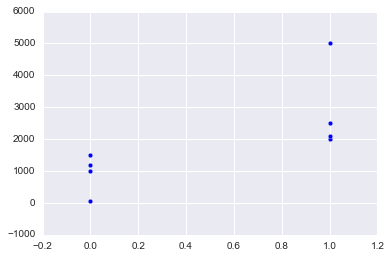

In [62]:
# не доверяйте средним значениям за весь тест. Вы можете упустить выбросы, например, пики из за GC.
sns.plt.scatter(df['pythonista'], df['salary'])

## Загрузим лог в Pandas

**вспомогательные материалы**: [Генераторы](https://wiki.python.org/moin/Generators) в python

**код**:

```
regex = re.compile('([\w\-\.@\'*,:/#&]+) - - \[(.*?)\] "([A-Z]+)\s+(\S+).*" (\d+) (-|\d+)')
delim = re.compile("[#?]")

def parse_log_re(file):
    for line in file:
        try:
            # заодно отделим параметры от урла
            fields = regex.match(line).groups()
            uri_parts = delim.split(fields[3], 1)
            uri = uri_parts[0]
            if len(uri_parts) > 1:
                params = uri_parts[1]
            else:
                params = None
            yield list(fields) + [uri, params]
        except AttributeError:
            pass

columns = "host ts method uri code size url params".split()
with open("./access_log_Jul95", encoding="ascii", errors="replace") as datafile:
    df = pd.DataFrame.from_records(parse_log_re(datafile), columns=columns)
```

In [63]:
regex = re.compile('([\w\-\.@\'*,:/#&]+) - - \[(.*?)\] "([A-Z]+)\s+(\S+).*" (\d+) (-|\d+)')
delim = re.compile("[#?]")

def parse_log_re(file):
    for line in file:
        try:
            # заодно отделим параметры от урла
            fields = regex.match(line).groups()
            uri_parts = delim.split(fields[3], 1)
            uri = uri_parts[0]
            if len(uri_parts) > 1:
                params = uri_parts[1]
            else:
                params = None
            yield list(fields) + [uri, params]
        except AttributeError:
            pass

columns = "host ts method uri code size url params".split()
with open("./access_log_Jul95", encoding="ascii", errors="replace") as datafile:
    df = pd.DataFrame.from_records(parse_log_re(datafile), columns=columns)

In [64]:
df.head()

,host,ts,method,uri,code,size,url,params
0,199.72.81.55,01/Jul/1995:00:00:01 -0400,GET,/history/apollo/,200,6245,/history/apollo/,None
1,unicomp6.unicomp.net,01/Jul/1995:00:00:06 -0400,GET,/shuttle/countdown/,200,3985,/shuttle/countdown/,None
2,199.120.110.21,01/Jul/1995:00:00:09 -0400,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,4085,/shuttle/missions/sts-73/mission-sts-73.html,None
3,burger.letters.com,01/Jul/1995:00:00:11 -0400,GET,/shuttle/countdown/liftoff.html,304,0,/shuttle/countdown/liftoff.html,None
4,199.120.110.21,01/Jul/1995:00:00:11 -0400,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,200,4179,/shuttle/missions/sts-73/sts-73-patch-small.gif,None


In [65]:
df.dtypes

host      object
ts        object
method    object
uri       object
code      object
size      object
url       object
params    object
dtype: object

In [67]:
df["size"] = pd.to_numeric(df["size"], errors='coerce')
df["ts"] = pd.to_datetime(df["ts"], format="%d/%b/%Y:%H:%M:%S -0400")

In [68]:
df.dtypes

host              object
ts        datetime64[ns]
method            object
uri               object
code              object
size             float64
url               object
params            object
dtype: object

In [69]:
df.head()

,host,ts,method,uri,code,size,url,params
0,199.72.81.55,1995-07-01 00:00:01,GET,/history/apollo/,200,6245.0,/history/apollo/,None
1,unicomp6.unicomp.net,1995-07-01 00:00:06,GET,/shuttle/countdown/,200,3985.0,/shuttle/countdown/,None
2,199.120.110.21,1995-07-01 00:00:09,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,4085.0,/shuttle/missions/sts-73/mission-sts-73.html,None
3,burger.letters.com,1995-07-01 00:00:11,GET,/shuttle/countdown/liftoff.html,304,0.0,/shuttle/countdown/liftoff.html,None
4,199.120.110.21,1995-07-01 00:00:11,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,200,4179.0,/shuttle/missions/sts-73/sts-73-patch-small.gif,None


In [70]:
# булевы операции в numpy
a = np.array([True, True, False, False])
b = np.array([True, False, True, False])
print("~a:", ~a)
print("a & b:", a & b)
print("a | b:", a | b)

~a: [False False  True  True]
a & b: [ True False False False]
a | b: [ True  True  True False]


In [71]:
# посмотрим, какие бывают параметры в урлах
df[~df["params"].isnull()]

,host,ts,method,uri,code,size,url,params
47,205.189.154.54,1995-07-01 00:01:06,GET,"/cgi-bin/imagemap/countdown?99,176",302,110.0,/cgi-bin/imagemap/countdown,"99,176"
89,remote27.compusmart.ab.ca,1995-07-01 00:01:53,GET,"/cgi-bin/imagemap/countdown?102,174",302,110.0,/cgi-bin/imagemap/countdown,"102,174"
137,onyx.southwind.net,1995-07-01 00:02:27,GET,"/cgi-bin/imagemap/countdown?103,146",302,96.0,/cgi-bin/imagemap/countdown,"103,146"
145,gater3.sematech.org,1995-07-01 00:02:41,GET,"/cgi-bin/imagemap/countdown?99,173",302,110.0,/cgi-bin/imagemap/countdown,"99,173"
161,onyx.southwind.net,1995-07-01 00:03:00,GET,"/cgi-bin/imagemap/countdown?102,210",302,95.0,/cgi-bin/imagemap/countdown,"102,210"
178,lmsmith.tezcat.com,1995-07-01 00:03:13,GET,"/cgi-bin/imagemap/countdown?103,175",302,110.0,/cgi-bin/imagemap/countdown,"103,175"
190,www-a1.proxy.aol.com,1995-07-01 00:03:20,GET,"/cgi-bin/imagemap/countdown?107,144",302,96.0,/cgi-bin/imagemap/countdown,"107,144"
211,205.189.154.54,1995-07-01 00:03:45,GET,"/cgi-bin/imagemap/countdown?108,176",302,110.0,/cgi-bin/imagemap/countdown,"108,176"
231,www-a1.proxy.aol.com,1995-07-01 00:04:01,GET,"/cgi-bin/imagemap/countdown?99,113",302,111.0,/cgi-bin/imagemap/countdown,"99,113"
270,gater3.sematech.org,1995-07-01 00:04:31,GET,"/cgi-bin/imagemap/countdown?370,274",302,68.0,/cgi-bin/imagemap/countdown,"370,274"


array([<matplotlib.axes._subplots.AxesSubplot object at 0x15d783710>], dtype=object)

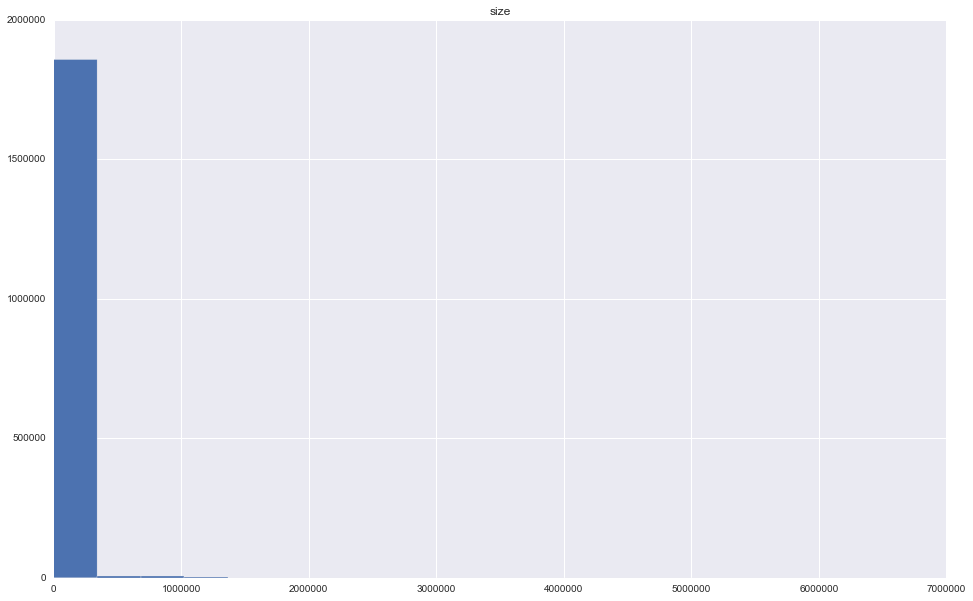

In [75]:
# построим распределение размеров ответов

# создаем оси, чтобы можно было задать размер
fig, ax = sns.plt.subplots()
# и задаем размер
fig.set_size_inches(16,10)
# в параметрах указываем оси
df[["size"]].hist(bins=20, ax=ax)

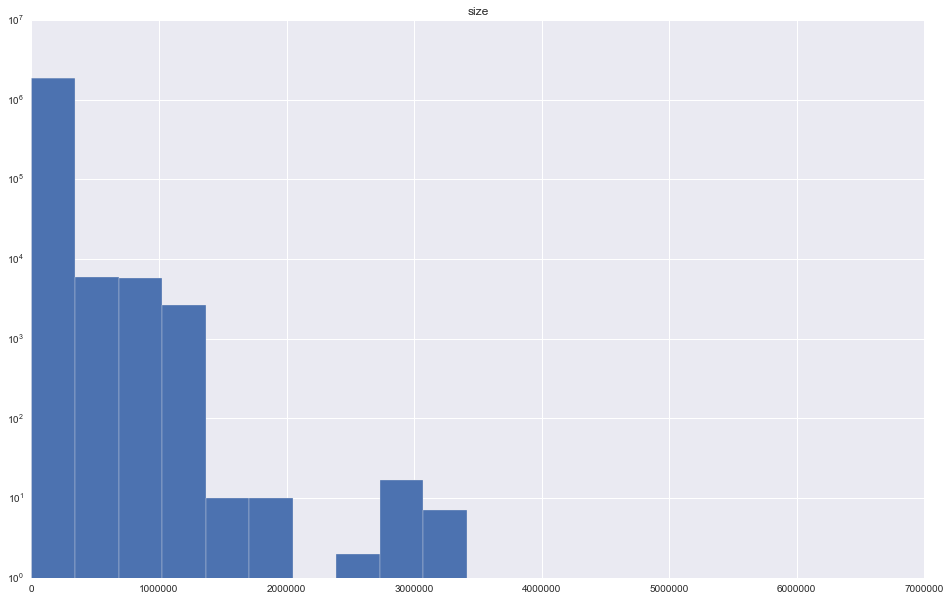

In [76]:
# логарифмический масштаб по оси y
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
df[["size"]].hist(bins=20, ax=ax)

# задаем логарифмический размер
ax.set_yscale("log")

## Минизадачка 5: Посмотреть, что за пик

**Задание** Посмотреть, какие запросы относятся к пику, который мы видим на графике.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [80]:
#butorov
df[df['size'] > 2000000]

,host,ts,method,uri,code,size,url,params
162842,ottgate2.bnr.ca,1995-07-03 12:30:07,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
207794,www-b6.proxy.aol.com,1995-07-03 22:02:47,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
265061,disarray.demon.co.uk,1995-07-04 17:20:20,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
301035,poppy.hensa.ac.uk,1995-07-05 07:54:02,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
305026,n164576.ksc.nasa.gov,1995-07-05 08:57:07,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
356013,gateway.cary.ibm.com,1995-07-05 17:21:54,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
406098,163.205.156.16,1995-07-06 10:19:00,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
417781,e659229.boeing.com,1995-07-06 12:11:57,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
477557,ttacs3.ttu.edu,1995-07-06 23:15:56,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
508838,spider.tbe.com,1995-07-07 10:28:56,GET,/statistics/1995/bkup/Mar95_full.html,200,3155499.0,/statistics/1995/bkup/Mar95_full.html,None


In [77]:
df[df["size"] > 2500000]

,host,ts,method,uri,code,size,url,params
162842,ottgate2.bnr.ca,1995-07-03 12:30:07,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
207794,www-b6.proxy.aol.com,1995-07-03 22:02:47,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
265061,disarray.demon.co.uk,1995-07-04 17:20:20,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
301035,poppy.hensa.ac.uk,1995-07-05 07:54:02,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
305026,n164576.ksc.nasa.gov,1995-07-05 08:57:07,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
356013,gateway.cary.ibm.com,1995-07-05 17:21:54,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
406098,163.205.156.16,1995-07-06 10:19:00,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
417781,e659229.boeing.com,1995-07-06 12:11:57,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
477557,ttacs3.ttu.edu,1995-07-06 23:15:56,GET,/statistics/1995/Jun/Jun95_reverse_domains.html,200,2973350.0,/statistics/1995/Jun/Jun95_reverse_domains.html,None
508838,spider.tbe.com,1995-07-07 10:28:56,GET,/statistics/1995/bkup/Mar95_full.html,200,3155499.0,/statistics/1995/bkup/Mar95_full.html,None


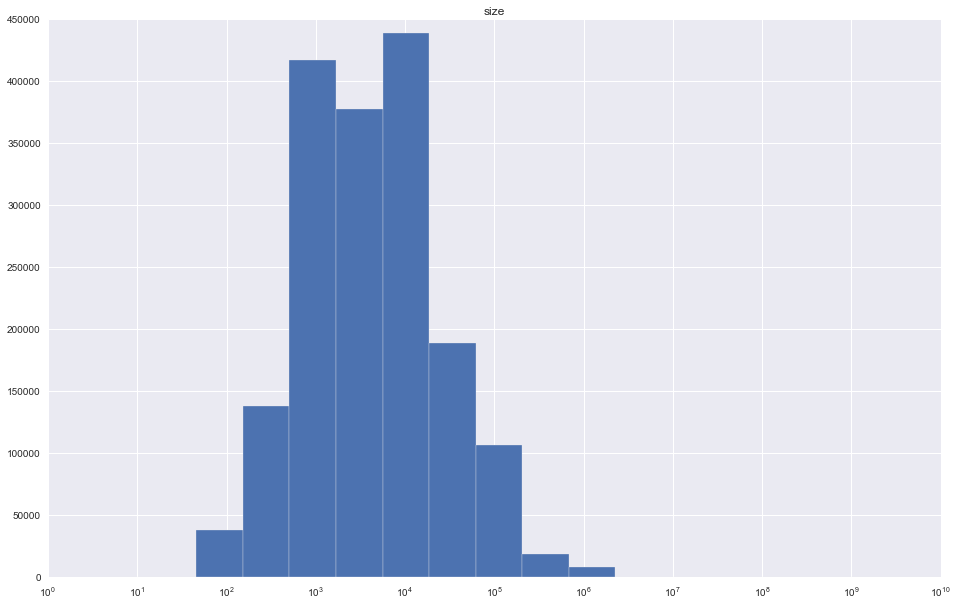

In [79]:
# чтобы сделать логарифмический масштаб по оси x, нам нужны логарифмические бины
# сгенерим их с помощью numpy.logspace
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)

# обратите внимание на параметр bins
df[["size"]].hist(bins=np.logspace(0.1, 10.0, 20), ax=ax)
#df[["size"]].hist(bins=20, ax=ax)


# логарифмический масштаб оси по x
ax.set_xscale("log")

## Задачка 6: считаем RPS на сервере

**Задание**: найти число запросов в секунду для каждой секунды, когда они были

In [81]:
# khudyakovavi
df.groupby('ts').size()

ts
1995-07-01 00:00:01    1
1995-07-01 00:00:06    1
1995-07-01 00:00:09    1
1995-07-01 00:00:11    2
1995-07-01 00:00:12    3
1995-07-01 00:00:13    2
1995-07-01 00:00:14    3
1995-07-01 00:00:15    3
1995-07-01 00:00:17    2
1995-07-01 00:00:18    1
1995-07-01 00:00:19    2
1995-07-01 00:00:24    1
1995-07-01 00:00:25    1
1995-07-01 00:00:27    1
1995-07-01 00:00:29    1
1995-07-01 00:00:33    1
1995-07-01 00:00:35    1
1995-07-01 00:00:37    1
1995-07-01 00:00:38    1
1995-07-01 00:00:40    1
1995-07-01 00:00:41    5
1995-07-01 00:00:43    1
1995-07-01 00:00:44    1
1995-07-01 00:00:50    1
1995-07-01 00:00:54    1
1995-07-01 00:00:58    1
1995-07-01 00:00:59    2
1995-07-01 00:01:02    1
1995-07-01 00:01:04    3
1995-07-01 00:01:05    1
                      ..
1995-07-28 13:31:46    4
1995-07-28 13:31:47    3
1995-07-28 13:31:49    6
1995-07-28 13:31:50    5
1995-07-28 13:31:51    3
1995-07-28 13:31:52    2
1995-07-28 13:31:53    2
1995-07-28 13:31:54    1
1995-07-28 13:31:55   

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

In [82]:
rps = df.groupby("ts")[["method"]].count()
rps.head()

,method
ts,
1995-07-01 00:00:01,1
1995-07-01 00:00:06,1
1995-07-01 00:00:09,1
1995-07-01 00:00:11,2
1995-07-01 00:00:12,3


In [83]:
rps.max()

method    20
dtype: int64

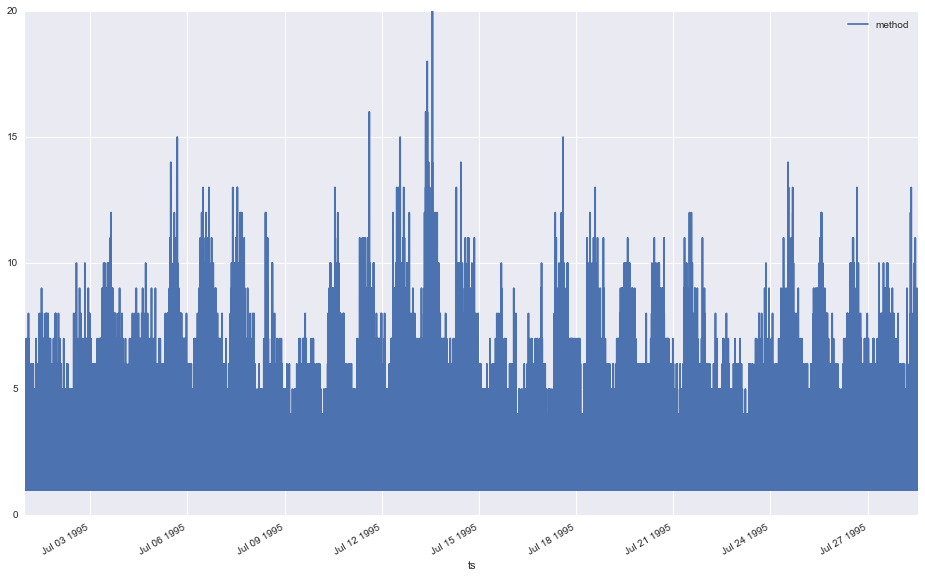

In [84]:
# построим график RPS
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
rps.plot(ax=ax)

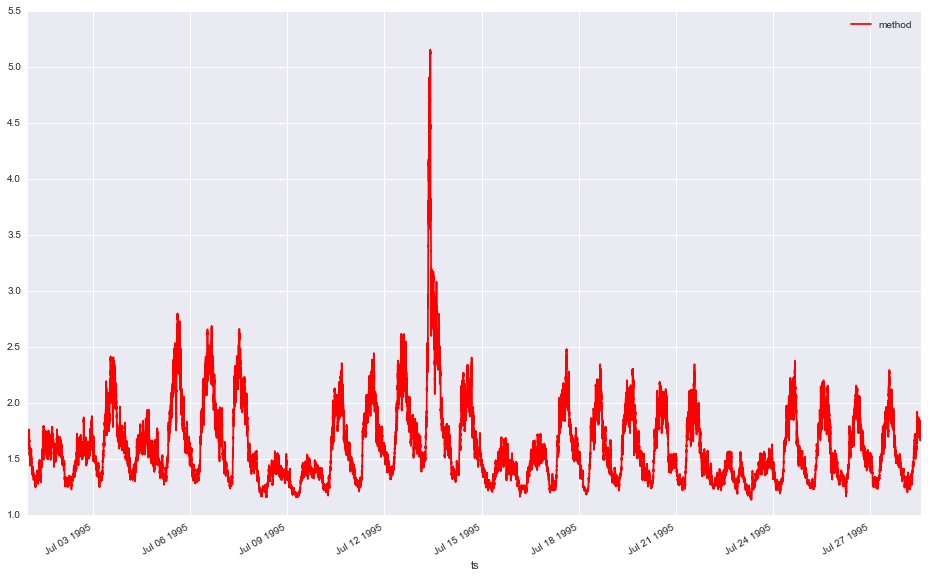

In [85]:
# добавим скользящее среднее, чтобы сгладить пики
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
#rps.plot(ax=ax)

# rolling сделает нам группы, используя скользящее окно, по которым можно считать разное
roll = rps.rolling(window=600)
roll.mean().plot(ax=ax, c="red")

## Творческая задачка 7: исследовать пик

**Задание**: узнать, с чем связан пик на графике

In [88]:
#vanadium23
from datetime import datetime
df[df['ts'] > datetime(1995, 7, 13)][df['ts'] < datetime(1995, 7, 15)].groupby('uri').count()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,host,ts,method,code,size,url,params
uri,,,,,,,
/,3162,3162,3162,3162,3162,3162,0
/%3A//spacelink.msfc.nasa.gov,5,5,5,5,0,5,0
/%3A/spacelink.msfc.nasa.gov,16,16,16,16,0,16,0
/%7Emol,1,1,1,1,0,1,0
/.ksc.html,2,2,2,2,2,2,0
//facilities/spaceport.html,1,1,1,1,1,1,0
//history/history/history.html,1,1,1,1,0,1,0
//ksc.html,1,1,1,1,1,1,0
//shuttle/missions/missions.html,1,1,1,1,1,1,0


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

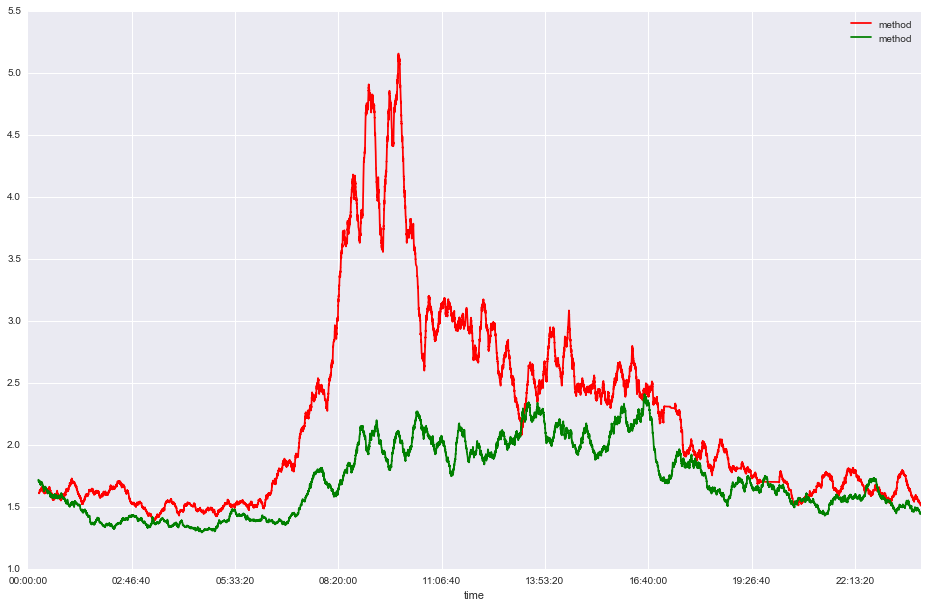

In [89]:
# для начала сравним на одном графике обычный и необычный дни

# возьмем время без даты
df['time'] = df["ts"].dt.time

# и отсеим нужные нам данные
event = df[
    (df['ts'] > pd.Timestamp("1995-07-13 00:00:00")) &
    (df['ts'] < pd.Timestamp("1995-07-14 00:00:00"))
]
no_event = df[
    (df['ts'] > pd.Timestamp("1995-07-14 00:00:00")) &
    (df['ts'] < pd.Timestamp("1995-07-15 00:00:00"))
]

# оси
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)

# скользящее среднее для дня с событием
event_rps = event.groupby("time")[["method"]].count()
event_roll = event_rps.rolling(window=600)
event_roll.mean().plot(ax=ax, c="red")

# скользящее среднее для дня без события
no_event_rps = no_event.groupby("time")[["method"]].count()
no_event_roll = no_event_rps.rolling(window=600)
no_event_roll.mean().plot(ax=ax, c="green")

In [90]:
# урлы, на которые ходили в четверг, но не ходили в пятницу
set(event['url']) - set(no_event['url'])

{'/BROWSER',
 '/General/Internet/WWW/Grobe.html',
 '/HISTORY/APOLLO/',
 '/HTBIN/CDT_CLOCK.PL',
 '/Images/blueball.gif',
 '/MISC',
 '/NASA_home.html',
 '/NIS',
 '/Organizations/Grumman/Products/Space_Technologies/LEM.html',
 '/Organizations/Grumman/Products/Space_Technologies/SpaceStation.html',
 '/Pictures/MoonFlag.gif',
 '/SHUTTLE/COUNTDOWN/',
 '/Shuttle',
 '/Shuttle/Countdown',
 '/astro-2.msfc.nasa.gov',
 '/base-ops/procurement/kscbus.htm',
 '/biomed/gif/aerpcfinmed.gif',
 '/biomed/intro.html',
 '/biomed/text/launch.doc',
 '/cgi-bin/imagemap/KSC-95EC-0823.jpg',
 '/cgi-bin/imagemap/count70.gif',
 '/cgi-bin/imagemap/lo-org',
 '/cgi-bin/imagemap/thunder.atms.purdue.edu',
 '/cgi-bin/imagemap/weatstat/weatinfo.htm',
 '/cgi-bin/imagemap/~tfish/oregon.map',
 '/countdown',
 '/countdown/',
 '/cwis/organizations/kucia/uroulette/jayhawk.gif',
 '/cwis/organizations/kucia/uroulette/press',
 '/cwis/organizations/kucia/uroulette/sig.gif',
 '/elv',
 '/elv/',
 '/elv/ATLAS_CENTAUR/goes_lau.gif',
 '/el

In [91]:
# посмотрим на разницу в топ100
visits_event = event.groupby('url')[['method']].count().sort_values(by='method', ascending=False)
visits_no_event = no_event.groupby('url')[['method']].count().sort_values(by='method', ascending=False)
set(visits_event[:100].index) - set(visits_no_event[:100].index)

{'/facilities/lcc.html',
 '/history/apollo/apollo-13/images/',
 '/icons/movie.xbm',
 '/images/launch-small.gif',
 '/shuttle/countdown/count.html',
 '/shuttle/countdown/images/cdtclock.gif',
 '/shuttle/countdown/video/livevideo.gif',
 '/shuttle/missions/',
 '/shuttle/missions/sts-70/images/KSC-95EC-0667.jpg',
 '/shuttle/missions/sts-70/images/KSC-95EC-0852.jpg',
 '/shuttle/missions/sts-70/images/index70.gif',
 '/shuttle/missions/sts-70/sts-70-info.html',
 '/shuttle/missions/sts-70/sts-70-patch.jpg',
 '/shuttle/missions/sts-70/sts-70-press-kit.txt',
 '/shuttle/technology/images/tal_abort_2-small.gif',
 '/shuttle/technology/sts-newsref/sts-lcc.html'}

https://en.wikipedia.org/wiki/STS-70

# Анализируем результаты стрельб Танком

In [92]:
# функция для импорта сырого отчета phantom

phout_columns = [
    'time', 'tag', 'interval_real',
    'connect_time', 'send_time',
    'latency', 'receive_time',
    'interval_event', 'size_out',
    'size_in', 'net_code', 'proto_code']

def read_phout(filename):
    data = pd.read_csv(
        filename, sep='\t', names=phout_columns)
    
    # хитрые манипуляции с колонками
    
    # в логе есть время отправки и время выполнения запроса. Суммируем их и получается
    # время получения ответа - будем группировать по нему (заводим новую колонку)
    data['ts'] = data.time + data.interval_real / 1000000
    # округляем до секунды
    data['receive_sec'] = data.ts.astype(int)
    # и индексируем по этой секунде
    data.set_index(['receive_sec'], inplace=True)
    # для удобства посчитаем время ответа в миллисекундах
    data['rt_ms'] = data.interval_real / 1000
    
    return data

In [93]:
phout1 = read_phout("phout_1.log")
phout2 = read_phout("phout_2.log")

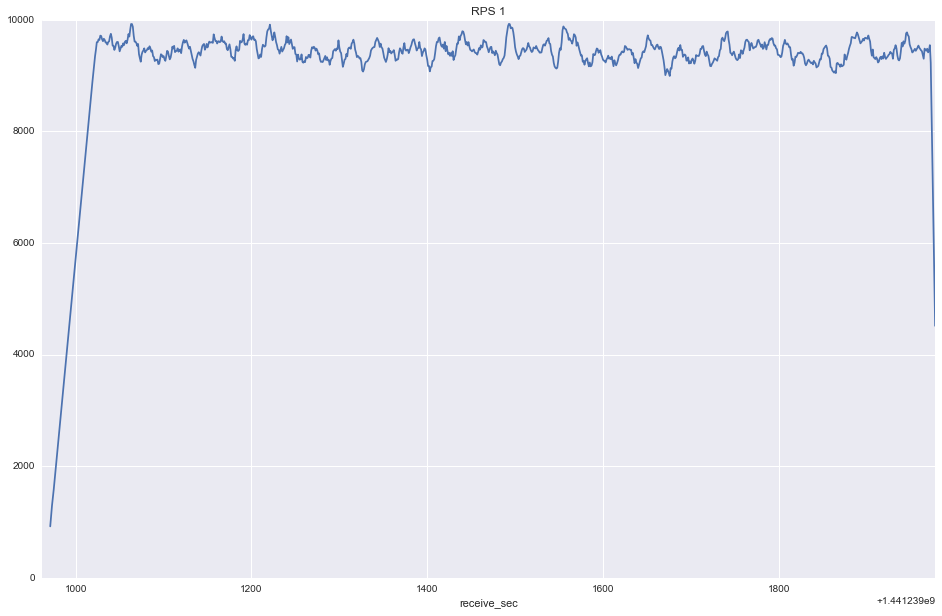

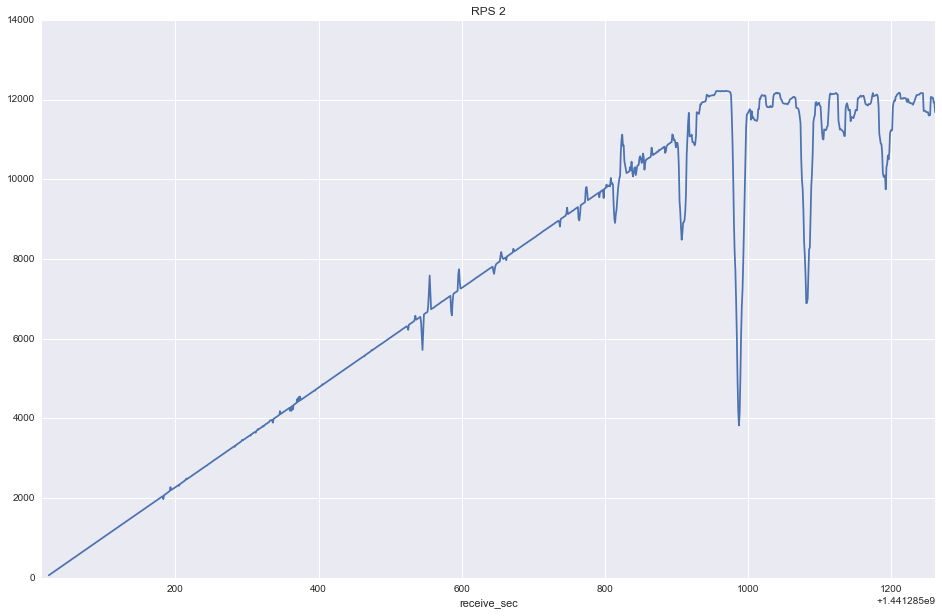

In [94]:
# графики RPS
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
phout1.groupby(level=0).count().time.rolling(window=10).mean().plot(title="RPS 1", ax=ax)

fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
phout2.groupby(level=0).count().time.rolling(window=10).mean().plot(title="RPS 2", ax=ax)

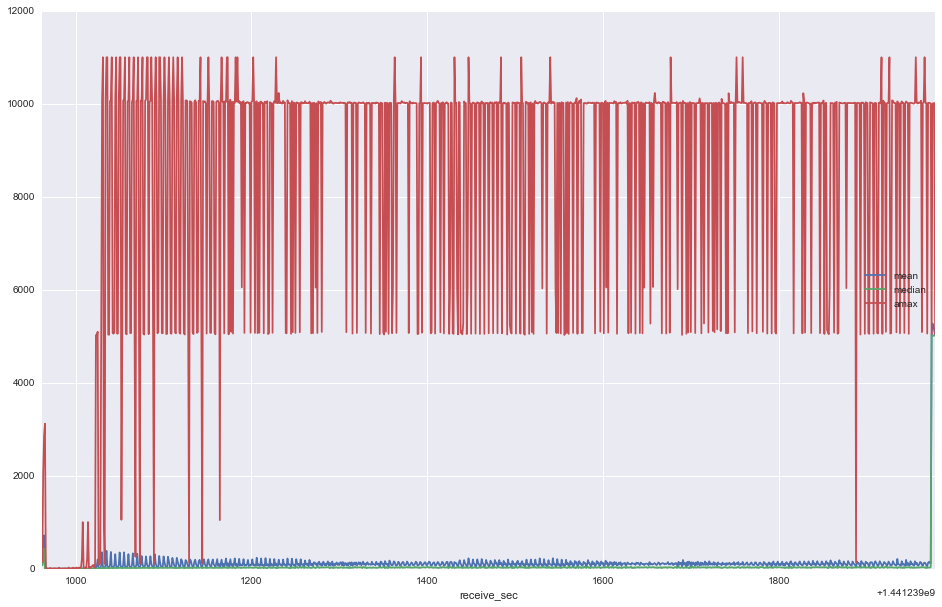

In [95]:
# группируем по индексу, считаем медиану, среднее и максимум и рисуем график
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
phout1.groupby(level=0).rt_ms.agg([np.mean, np.median, np.max]).plot(ax=ax)

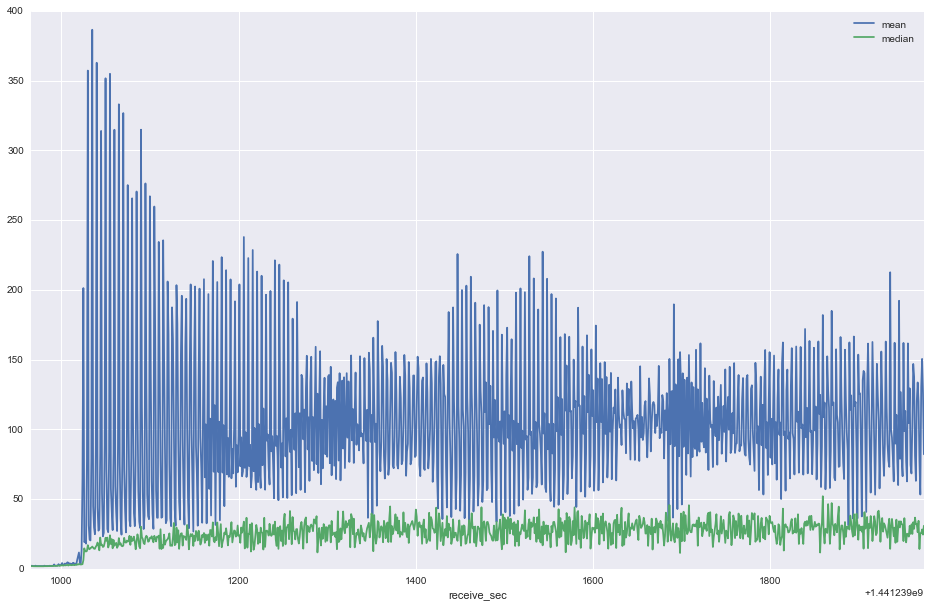

In [96]:
# медиана и среднее
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
phout1 = phout1[2000:-1000]
phout1.groupby(level=0).rt_ms.agg([np.mean, np.median]).plot(ax=ax)

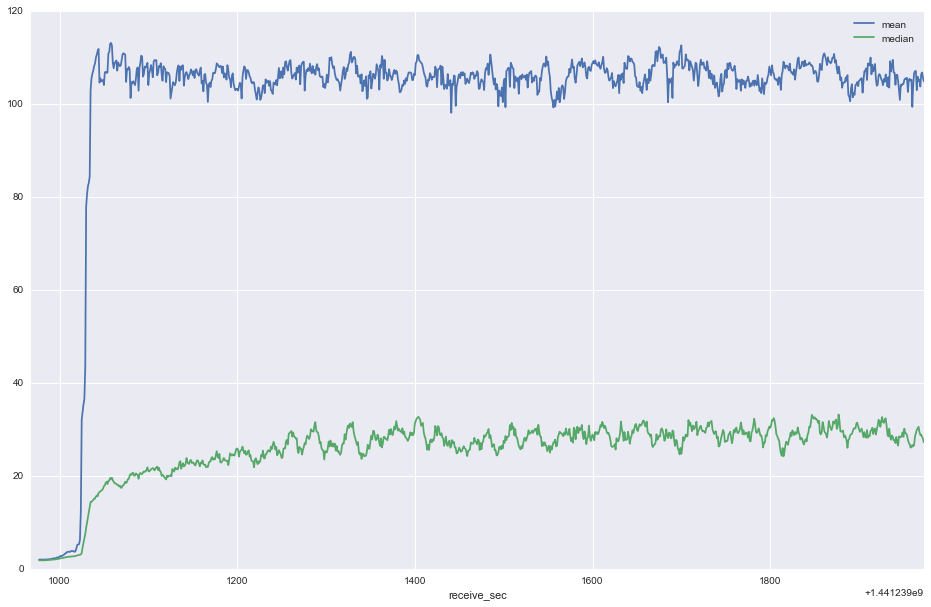

In [97]:
# сглаженные медиана и среднее
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
phout1 = phout1[2000:-1000]
phout1.groupby(level=0).rt_ms.agg([np.mean, np.median]).rolling(window=10).mean().plot(ax=ax)

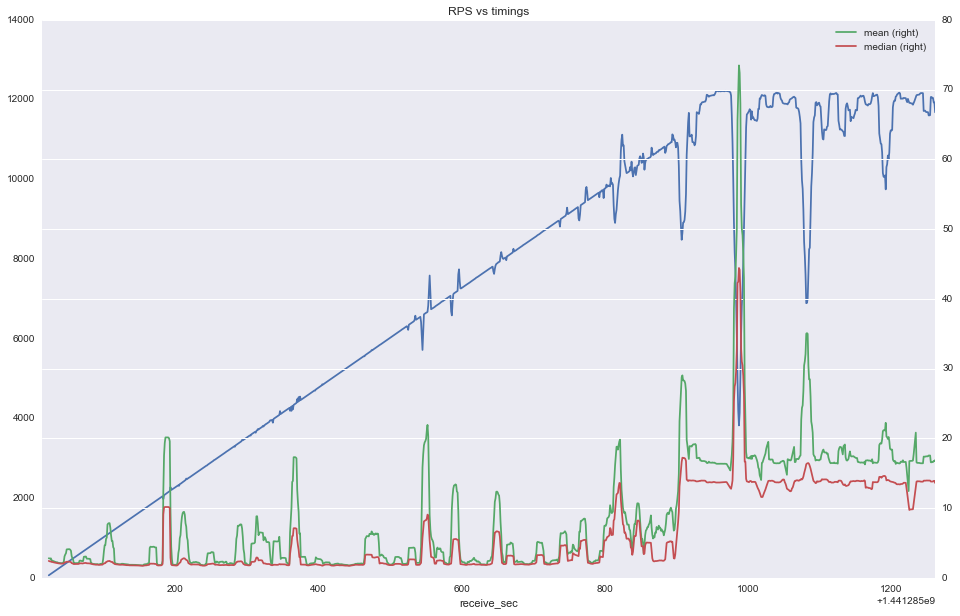

In [98]:
# сглаженные медиана, среднее и rps на одном графике для второго лога
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
phout2.groupby(level=0).count().time.rolling(window=10).mean().plot(title="RPS vs timings", ax=ax)
phout2.groupby(level=0).rt_ms.agg([np.mean, np.median]).rolling(window=10).mean().plot(ax=ax, secondary_y=True)

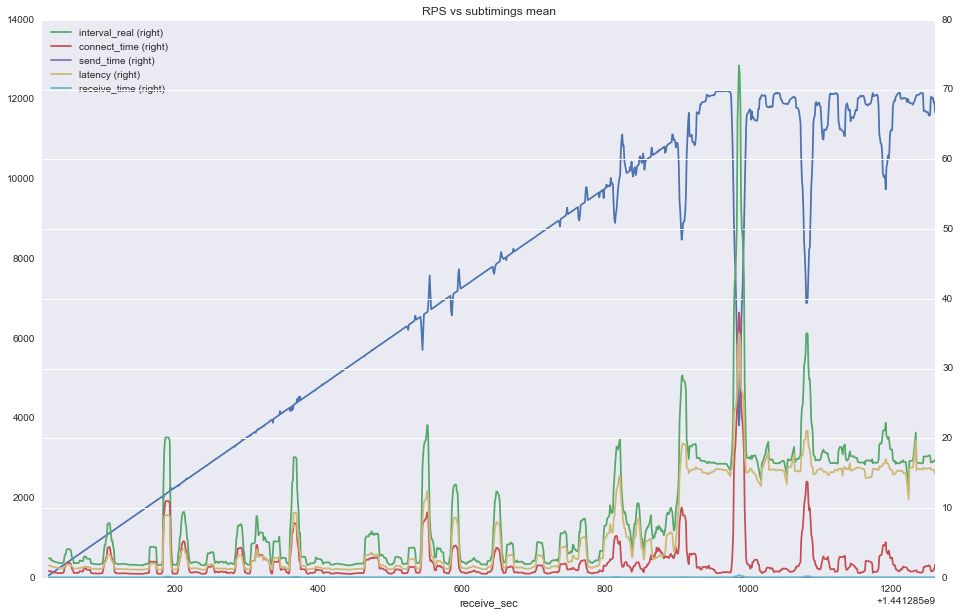

In [99]:
# сглаженные медиана, среднее и rps на одном графике для времен соединения, отправки, обработки и получения данных
fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
phout2.groupby(level=0).count().time.rolling(window=10).mean().plot(title="RPS vs subtimings mean", ax=ax)
(phout2[[
    "interval_real", 'connect_time', 'send_time',
    'latency', 'receive_time']] / 1000.0).groupby(level=0).agg(np.mean).rolling(window=10).mean().plot(ax=ax, secondary_y=True)

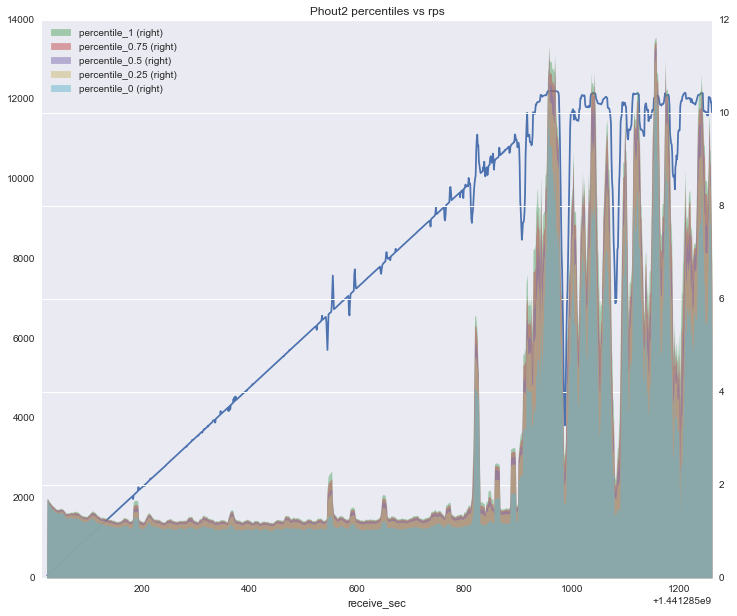

In [100]:
# процентильный график

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_
percentiles = [percentile(n) for n in [1, .75, .5, .25, 0]]

fig, ax = sns.plt.subplots()
fig.set_size_inches(16,10)
phout2.groupby(level=0).count().time.rolling(window=10).mean().plot(title="RPS vs timings", ax=ax)

phout2.groupby(level=0).rt_ms.agg(percentiles).rolling(window=10).mean().plot(
    title='Phout2 percentiles vs rps', kind='area', stacked=False, figsize=(12, 10), linewidth=0, ax=ax, secondary_y=True)